# Spam Email Classifier Project

## Project Description
This project details the various steps that I took to build my own spam email classifier that is able to classify an email as spam or non-spam(ham) via a set of its features. 

I obtained the dataset for this project through Kaggle: https://www.kaggle.com/datasets/nitishabharathi/email-spam-dataset?resource=download. In particular, I have used the 'completeSpamAssassin.csv' dataset for this project. It simply includes a serial number column that can be used as the index, a body column that contains the actual text content of each email, and the label column that is 0 for ham emails and 1 for spam emails.

From the dataset, it is straightforward that we may use a vectorizer (count/TD-IDF) to extract features from the email body column. However, for this project, I have implemented some feature engineering to attempt at producing more features (in addition to the ones extracted from a TF-IDF vectorizer) that can enhance the performance of the spam email classifier. I have also implemented several different Machine Learning algorithms to identify the best one.

Topics covered in this project are:
- Supervised Machine Learning
- Binary Classification
- Natural Language Processing
- Data Visualisation
- Data Manipulation & Analysis
- Feature Engineering
- Model Evaluation

# Importing Core Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# Reading in Data

In [2]:
emails = pd.read_csv('completeSpamAssassin.csv')
emails = emails.rename(columns={'Unnamed: 0':'Index'})
emails = emails.set_index('Index')

#emails[emails['Body'].isna()] 
#Only the row of index 328 has NaN value, removing the row should not significantly change the class distribution
emails = emails.dropna()
emails

,Body,Label
Index,,
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1
...,...,...
6041,empty,0
6042,___ ___ ...,0
6043,IN THIS ISSUE:01. Readers write\n02. Extension...,0


# Text Preprocessing

In [3]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def token_lemma(text, lemmatizer=lemmatizer, stopwords=stopwords):
    word_tokens = nltk.word_tokenize(text)
    new_text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens if w not in set(stopwords)])
    return new_text

lemmatized = emails['Body'].apply(lambda x: token_lemma(x))
emails1 = emails.copy()
emails1['Body'] = lemmatized

# TF-IDF Vectorization w/o Feature Engineering

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = emails1[['Body']]
y = emails1['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['Body'])
X_test_vec = vectorizer.transform(X_test['Body'])

# Multinomial Naive Bayes Classification

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

mnb_clf = MultinomialNB().fit(X_train_vec, y_train)
acc_train = mnb_clf.score(X_train_vec, y_train)
acc_test = mnb_clf.score(X_test_vec, y_test)
auc_train = roc_auc_score(y_train, mnb_clf.predict_proba(X_train_vec)[:, 1])
auc_test = roc_auc_score(y_test, mnb_clf.predict_proba(X_test_vec)[:, 1])

print('MNB accuracy for training set: {}'.format(acc_train))
print('MNB accuracy for test set: {}'.format(acc_test))
print('MNB AUC score for training set: {}'.format(auc_train))
print('MNB AUC score for test set: {}'.format(auc_test))

MNB accuracy for training set: 0.8960953011250827
MNB accuracy for test set: 0.8829365079365079
MNB AUC score for training set: 0.9882911545255229
MNB AUC score for test set: 0.9831897899899217


# Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_vec, y_train)
acc_train1 = logreg.score(X_train_vec, y_train)
acc_test1 = logreg.score(X_test_vec, y_test)
auc_train1 = roc_auc_score(y_train, logreg.predict_proba(X_train_vec)[:, 1])
auc_test1 = roc_auc_score(y_test, logreg.predict_proba(X_test_vec)[:, 1])

print('Logreg accuracy for training set: {}'.format(acc_train1))
print('Logreg accuracy for test set: {}'.format(acc_test1))
print('Logreg AUC score for training set: {}'.format(auc_train1))
print('Logreg AUC score for test set: {}'.format(auc_test1))

Logreg accuracy for training set: 0.9534524597396867
Logreg accuracy for test set: 0.9464285714285714
Logreg AUC score for training set: 0.9895824070065737
Logreg AUC score for test set: 0.9889403823234193


# Support Vector Machine

In [7]:
from sklearn.svm import SVC

svc = SVC().fit(X_train_vec, y_train)
acc_train2 = svc.score(X_train_vec, y_train)
acc_test2 = svc.score(X_test_vec, y_test)
auc_train2 = roc_auc_score(y_train, svc.decision_function(X_train_vec))
auc_test2 = roc_auc_score(y_test, svc.decision_function(X_test_vec))

print('SVM accuracy for training set: {}'.format(acc_train2))
print('SVM accuracy for test set: {}'.format(acc_test2))
print('SVM AUC score for training set: {}'.format(auc_train2))
print('SVM AUC score for test set: {}'.format(auc_test2))

SVM accuracy for training set: 0.9671299360247076
SVM accuracy for test set: 0.9556878306878307
SVM AUC score for training set: 0.9863541629519553
SVM AUC score for test set: 0.9769649220000532


# Feature Engineering

In [8]:
import re

#remove all the line breaks (\n)
body_dropped = emails['Body'].apply(lambda x: re.sub('\n', ' ', x))

#create a feature for the number of words ([a-zA-Z]+) in each email's body
num_words = body_dropped.apply(lambda x: len(re.findall('[a-zA-Z]+', x)))
emails1['WordCount'] = num_words

#create a feature for the number of digits (\d+) in each email's body
num_digits = body_dropped.apply(lambda x: len(re.findall('\d+', x)))
emails1['NumCount'] = num_digits

#create a feature for the number of symbols ([^a-zA-Z0-9]) in each email's body
num_symbols = body_dropped.apply(lambda x: len(re.findall('[^a-zA-Z0-9\s]', x)))
emails1['SymCount'] = num_symbols

# Data Visualisation of New Features

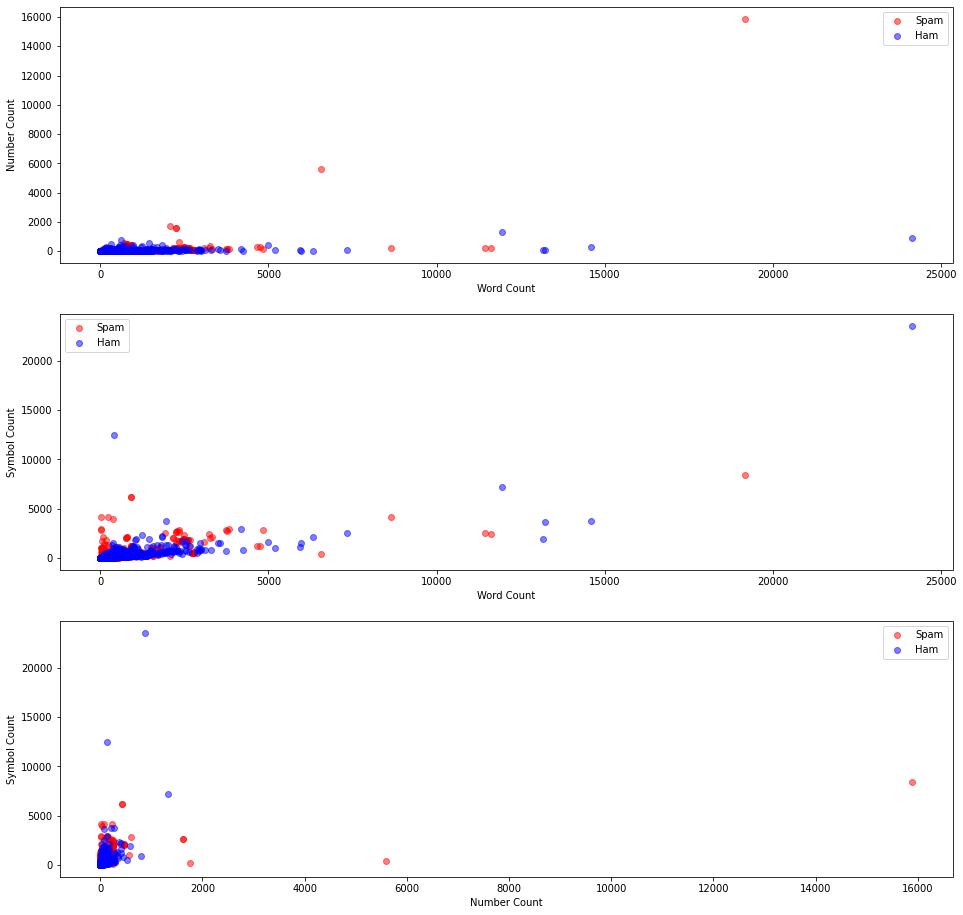

In [9]:
spams = emails1[emails1['Label'] == 1]
hams = emails1[emails1['Label'] == 0]

#scatterplots for spam and non-spam emails
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 16))
ax1.scatter(spams['WordCount'], spams['NumCount'], c='red', alpha=0.5, label='Spam')
ax1.scatter(hams['WordCount'], hams['NumCount'], c='blue', alpha=0.5, label='Ham')
ax1.legend()
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Number Count')

ax2.scatter(spams['WordCount'], spams['SymCount'], c='red', alpha=0.5, label='Spam')
ax2.scatter(hams['WordCount'], hams['SymCount'], c='blue', alpha=0.5, label='Ham')
ax2.legend()
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Symbol Count')

ax3.scatter(spams['NumCount'], spams['SymCount'], c='red', alpha=0.5, label='Spam')
ax3.scatter(hams['NumCount'], hams['SymCount'], c='blue', alpha=0.5, label='Ham')
ax3.legend()
ax3.set_xlabel('Number Count')
ax3.set_ylabel('Symbol Count')

plt.show()

# TF-IDF Vectorization w/ Feature Engineering

In [10]:
X_new = emails1[['Body', 'WordCount', 'NumCount', 'SymCount']]
y_new = emails1['Label']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_new, y_new, random_state=0)

vectorizer = TfidfVectorizer()
X_train1_vec = vectorizer.fit_transform(X_train1['Body'])
X_train1_all = np.hstack((X_train1_vec.toarray(), X_train1[['WordCount', 'NumCount', 'SymCount']]))
X_test1_vec = vectorizer.transform(X_test1['Body'])
X_test1_all = np.hstack((X_test1_vec.toarray(), X_test1[['WordCount', 'NumCount', 'SymCount']]))

# Multinomial Naive Bayes Classification w/ Feature Engineering

In [11]:
mnb_clf1 = MultinomialNB().fit(X_train1_all, y_train1)
acc_trainfe = mnb_clf1.score(X_train1_all, y_train1)
acc_testfe = mnb_clf1.score(X_test1_all, y_test1)
auc_trainfe = roc_auc_score(y_train1, mnb_clf1.predict_proba(X_train1_all)[:, 1])
auc_testfe = roc_auc_score(y_test1, mnb_clf1.predict_proba(X_test1_all)[:, 1])

print('MNB accuracy for training set: {}'.format(acc_trainfe))
print('MNB accuracy for test set: {}'.format(acc_testfe))
print('MNB AUC score for training set: {}'.format(auc_trainfe))
print('MNB AUC score for test set: {}'.format(auc_testfe))

MNB accuracy for training set: 0.7193911317008603
MNB accuracy for test set: 0.7076719576719577
MNB AUC score for training set: 0.6738158779140077
MNB AUC score for test set: 0.6599249336116295


# Logistic Regression w/ Feature Engineering

In [12]:
logreg1 = LogisticRegression(max_iter=1000).fit(X_train1_all, y_train1)
acc_train1fe = logreg1.score(X_train1_all, y_train1)
acc_test1fe = logreg1.score(X_test1_all, y_test1)
auc_train1fe = roc_auc_score(y_train1, logreg1.predict_proba(X_train1_all)[:, 1])
auc_test1fe = roc_auc_score(y_test1, logreg1.predict_proba(X_test1_all)[:, 1])

print('Logreg accuracy for training set: {}'.format(acc_train1fe))
print('Logreg accuracy for test set: {}'.format(acc_test1fe))
print('Logreg AUC score for training set: {}'.format(auc_train1fe))
print('Logreg AUC score for test set: {}'.format(auc_test1fe))

Logreg accuracy for training set: 0.9521288330024267
Logreg accuracy for test set: 0.9444444444444444
Logreg AUC score for training set: 0.9893172048277179
Logreg AUC score for test set: 0.9862378287987538


# Support Vector Machine w/ Feature Engineering

In [ ]:
'''
svc1 = SVC().fit(X_train1_all, y_train1)
acc_train2fe = svc1.score(X_train1_all, y_train1)
acc_test2fe = svc1.score(X_test1_all, y_test1)
auc_train2fe = roc_auc_score(y_train1, svc1.decision_function(X_train1_all))
auc_test2fe = roc_auc_score(y_test1, svc1.decision_function(X_test1_all))

print('SVM accuracy for training set: {}'.format(acc_train2fe))
print('SVM accuracy for test set: {}'.format(acc_test2fe))
print('SVM AUC score for training set: {}'.format(auc_train2fe))
print('SVM AUC score for test set: {}'.format(auc_test2fe))
'''
#The model takes too long to run 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


# Project Conclusion
From the model evaluation results, I can observe that in general, the logistic regression model has the best performance with and without feature engineering. It has the highest Area Under Curve (AUC) scores for the training and test sets, and also high accuracy scores. Roughly 0.98 for the AUC scores and 0.94 for the accuracy scores, which I would consider as good model performance.

One thing to notice is that the accuracy and AUC scores for the multinomial Naive Bayes model dropped rather significantly after feature engineering. From the scatterplots of the new features, I can observe that spam and ham emails typically overlap with one another in terms of the newly added 3 features, which may account for why the Naive Bayes model dipped in performance.

Hence, one key takeaway from this project is that the addition of new features via feature engineering may not always enhance the performance of a machine learning model. During the process of feature engineering, it is important to test whether new features actually improve the performance of our model through model evaluation, and things such as data visualisation can help us further investigate the usefulness of any new features. 